We are attempting to find predictors for energy generated at the Barra Bonita dam. We lag all the variables to which we have access and use random forests to find the most important indicators. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import datetime as dt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error

# TO DO: Import weather data

We work with data up to 2017 so that we can test the predictions on 2018-2021.

In [2]:
df = pd.read_csv("../../Data/1999_2021/aggragate_daily_data_2000to2020.csv", index_col = "date").drop(labels = "Unnamed: 0", axis = 1)
df_2017 = df.loc['2000-01-01':'2018-12-31'].copy()

Adding 3 day, 7 day, 14 day, 30 day lags to all variables.

In [3]:
df_2017_lagged = df_2017.copy()

for i in [3,7,14,30]:    #this is so UGLY I wish I knew how to code :(
    df_2017_lagged[['turbine_flow']] = (df_2017_lagged['effluent_flow'] - df_2017_lagged['poured_flow']).to_frame()
    df_2017_lagged[['energy_charge_' + str(i)]] = df_2017_lagged[['energy_charge']].shift(i)
    df_2017_lagged[['influent_flow_' + str(i)]] = df_2017_lagged[['influent_flow']].shift(i)
    df_2017_lagged[['volume_used_' + str(i)]] = df_2017_lagged[['volume_used']].shift(i)
    df_2017_lagged[['poured_flow_' + str(i)]] = df_2017_lagged[['poured_flow']].shift(i)
    df_2017_lagged[['water_level_' + str(i)]] = df_2017_lagged[['water_level']].shift(i)
    df_2017_lagged[['energy_stored_' + str(i)]] = df_2017_lagged[['energy_stored']].shift(i)
    df_2017_lagged[['maximum_demand_' + str(i)]] = df_2017_lagged[['maximum_demand']].shift(i)
    df_2017_lagged[['energy_generated_' + str(i)]] = df_2017_lagged[['energy_generated']].shift(i)
    df_2017_lagged[['turbine_flow_' + str(i)]] = df_2017_lagged[['turbine_flow']].shift(i)
    df_2017_lagged[['effluent_flow_' + str(i)]] = df_2017_lagged[['effluent_flow']].shift(i)
    
df_2017_lagged = df_2017_lagged.dropna()

# Regression Tree

Chose train size of (6908-n)/6908 so that we could test it on an n-day interval. (Not used here.) The strongest indicators of energy generated are turbine flow, effluent flow, energy generated lagged 3 days, effluent flow lagged 3 days.

In [4]:
X = df_2017_lagged.drop(['energy_generated'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (6908-90)/6908, random_state = 0)

regr_tree_daily = DecisionTreeRegressor(max_depth = 2)
regr_tree_daily.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

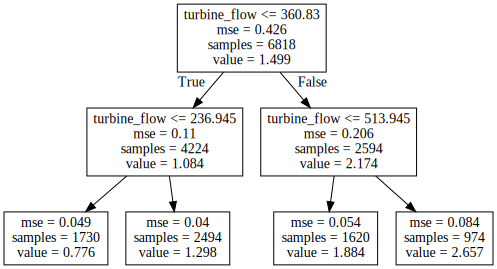

In [5]:
export_graphviz(regr_tree_daily, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

0.18891500327460015

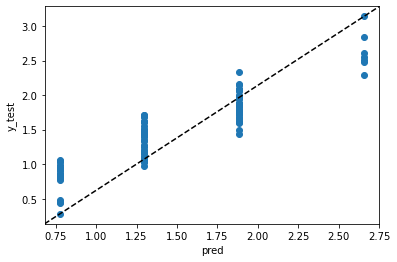

In [6]:
pred = regr_tree_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

## Bagging

Chose train size of (6908-n)/6908 so that we could test it on an n-day interval. 

In [7]:
X = df_2017_lagged.drop(['energy_generated'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (6908-90)/6908, random_state = 0)

In [8]:
bagged_daily = RandomForestRegressor(max_features = 13, random_state = 1)
bagged_daily.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

0.029181632265555535

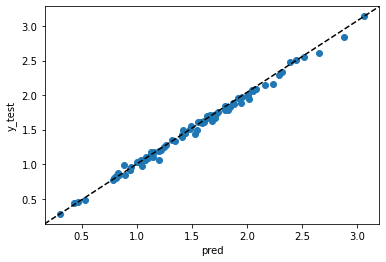

In [9]:
pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

**Choose a time chunk using .iloc to predict using the training model**

0.7330194138477778

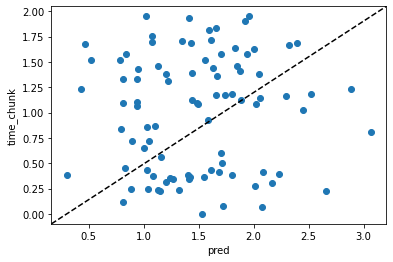

In [10]:
time_chunk = df[['energy_generated']].iloc[7210:7210+90].copy()

pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            time_chunk, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('time_chunk')

mean_absolute_error(time_chunk, pred)

## Random Forest

Chose train size of (6908-n)/6908 so that we could test it on an n-day interval. Forest shows that turbine flow and effluent flow are the most important indicators. Dropped these variables.

In [11]:
X = df_2017_lagged.drop(['energy_generated','turbine_flow','effluent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (6908-90)/6908, random_state = 0)

random_forest_daily = RandomForestRegressor(max_features = 7, random_state = 1)
random_forest_daily.fit(X_train, y_train)
pred = random_forest_daily.predict(X_test)
mean_absolute_error(y_test, random_forest_daily.predict(X_test))

0.21222722520888887

**Choosing time chunk on which to test forest's prediction**

In [12]:
time_chunk = df[['energy_generated']].iloc[7200:7200+90].copy()
mean_absolute_error(time_chunk, random_forest_daily.predict(X_test))

0.6705601787577777

In [13]:
Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns).sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = False)
Importance.head(10)

,Importance
energy_generated_3,12.729955
effluent_flow_3,10.257903
turbine_flow_3,8.612352
influent_flow_3,6.948552
energy_generated_7,6.937019
influent_flow,6.586252
effluent_flow_7,5.588889
turbine_flow_7,4.070409
influent_flow_7,3.061863
effluent_flow_14,2.447834


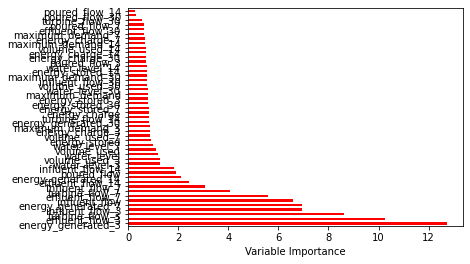

In [14]:
Importance.plot(kind = 'barh', color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# 8.3.4 Boosting

Same as random forest above but boosted.

In [15]:
X = df_2017_lagged.drop(['energy_generated','turbine_flow','effluent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = (6908-90)/6908, random_state = 0)

boosted_daily = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.2, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_daily.fit(X_train, y_train)
feature_importance = boosted_daily.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False,ascending = False)
rel_imp.head(10)

energy_generated_3    47.838476
energy_generated_7     9.871991
influent_flow_3        9.704493
influent_flow          5.253204
volume_used_3          1.842214
energy_charge_3        1.616238
energy_charge          1.508765
water_level_3          1.440399
maximum_demand         1.193065
turbine_flow_3         1.139866
dtype: float64

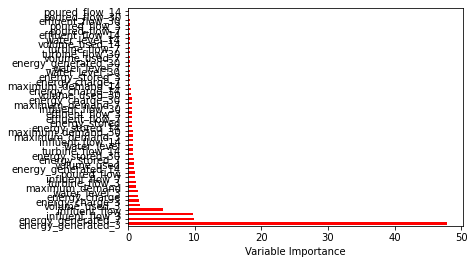

In [16]:
rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [17]:
mean_absolute_error(y_test, boosted_daily.predict(X_test))

0.20655317347631158

In [18]:
time_chunk = df[['energy_generated']].iloc[7200:7200+90].copy()
mean_absolute_error(time_chunk,  boosted_daily.predict(X_test))

0.7001360282389706

## Conclusion

It seems that turbine flow, energy generated, influent flow, and effluent flow are the best predictors of energy generated. Even lagged, these are better predictors than other variables (lagged and unlagged). Below is a correlation table of all these variables and some of their lags. 

In [19]:
df_2017_lagged[['energy_generated','energy_generated_3','energy_generated_7','turbine_flow','turbine_flow_3','turbine_flow_7','influent_flow','influent_flow_3','influent_flow_7','effluent_flow','effluent_flow_3','effluent_flow_7']].corr()

,energy_generated,energy_generated_3,energy_generated_7,turbine_flow,turbine_flow_3,turbine_flow_7,influent_flow,influent_flow_3,influent_flow_7,effluent_flow,effluent_flow_3,effluent_flow_7
energy_generated,1.000000,0.753128,0.670042,0.980606,0.737891,0.653967,0.565626,0.610313,0.563632,0.784184,0.645785,0.568019
energy_generated_3,0.753128,1.000000,0.712996,0.734265,0.980576,0.697758,0.462729,0.565540,0.606312,0.623159,0.784155,0.618380
energy_generated_7,0.670042,0.712996,1.000000,0.647677,0.693668,0.980572,0.390820,0.436552,0.565605,0.528657,0.587165,0.784095
turbine_flow,0.980606,0.734265,0.647677,1.000000,0.751492,0.661775,0.609231,0.642251,0.578032,0.838908,0.684488,0.592241
turbine_flow_3,0.737891,0.980576,0.693668,0.751492,1.000000,0.710126,0.504163,0.609271,0.632867,0.665392,0.838899,0.652356
turbine_flow_7,0.653967,0.697758,0.980572,0.661775,0.710126,1.000000,0.432405,0.477968,0.609425,0.561484,0.626339,0.838907
influent_flow,0.565626,0.462729,0.390820,0.609231,0.504163,0.432405,1.000000,0.737806,0.538722,0.777278,0.596434,0.478530
influent_flow_3,0.610313,0.565540,0.436552,0.642251,0.609271,0.477968,0.737806,1.000000,0.660316,0.760402,0.777255,0.551815
influent_flow_7,0.563632,0.606312,0.565605,0.578032,0.632867,0.609425,0.538722,0.660316,1.000000,0.590722,0.714986,0.777292
effluent_flow,0.784184,0.623159,0.528657,0.838908,0.665392,0.561484,0.777278,0.760402,0.590722,1.000000,0.769022,0.596579
